# NLP Topic Modeling

## Problem statement

Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.

Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 

Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 

1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

## Dataset

The dataset consists of three files `train.csv`, `test.csv` and `sample_submission.csv`.

|Fields| Description|
|-------|-----------|
|ID |Unique ID for each article|
|TITLE|Title of the research article|
|ABSTRACT|Abstract of the research article|
|Computer Science|Whether article belongs to topic computer science (1/0)|
|Physics	|Whether article belongs to topic physics (1/0)|
|Mathematics	|Whether article belongs to topic Mathematics (1/0)|
|Statistics	|Whether article belongs to topic Statistics (1/0)|
|Quantitative Biology	|Whether article belongs to topic Quantitative Biology (1/0)|
|Quantitative Finance|Whether article belongs to topic Quantitative Finance (1/0)|

## Approach

In this notebook, there are two approaches followed,
1. Preprocess the text data and convert them to pad sequence
2. Construct a **Recurrent Neural Network(RNN)** to train the dataset and predict the test data


##  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from gensim.models import Word2Vec # Word2Vec module
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric, stem_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##  Loading Dataset

In [2]:
# Training data
path1 ="train.csv"
path2 ="test.csv"
class DataFrame_Loader():

    
    def __init__(self):
        
        print("Loadind DataFrame")
        
    def load_train_csv(self,path1,path2):
        dftrain = pd.read_csv(path1)
        dftest = pd.read_csv(path2)
        return dftrain,dftest

In [3]:
load= DataFrame_Loader()

Loadind DataFrame


In [4]:
train_df,test_df = load.load_train_csv(path1,path2)
train_df.shape,test_df.shape

((20972, 9), (8989, 3))

In [5]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


Checking missing values and data columns.

In [9]:
print(train_df.isnull().sum())
print(train_df.columns)

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64
Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


## Data Exploration

In [6]:
# Converting binary column to category
target_cols = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [7]:
y_data = train_df[target_cols]
y_data.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,1,0,0


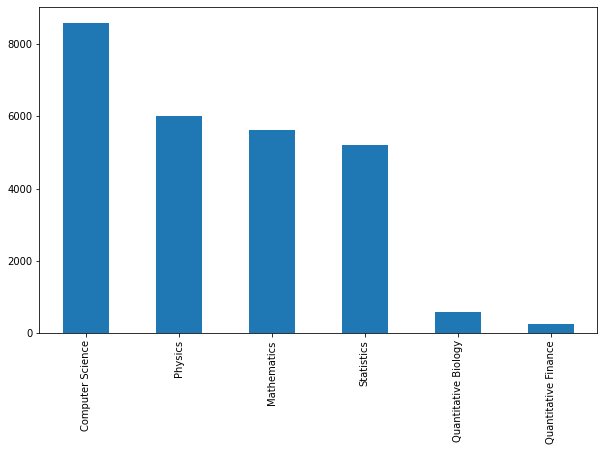

In [12]:
# Plot category data
plt.figure(figsize=(10,6))
y_data.sum(axis=0).plot.bar()
plt.show()


The data distribution is not balanced for all the classes. There are some imbalance sample data in the given training set.

## Data Preparation

In [8]:
# Stemmer object
porter = PorterStemmer()
wnl = WordNetLemmatizer()

class DataPreprocess:
    
    def __init__(self):
        self.filters = [strip_tags,
                       strip_numeric,
                       strip_punctuation,
                       lambda x: x.lower(),
                       lambda x: re.sub(r'\s+\w{1}\s+', '', x),
                       remove_stopwords]
    def __call__(self, doc):
        clean_words = self.__apply_filter(doc)
        return clean_words
    
    def __apply_filter(self, doc):
        try:
            cleanse_words = set(preprocess_string(doc, self.filters))
            return ' '.join(cleanse_words)
        except TypeError as te:
            raise(TypeError("Not a valid data {}".format(te)))

In [11]:
def proccessing_Data(train,test):
    
    
    feature_col = ['ID', 'TITLE', 'ABSTRACT', 'target']
    train['target'] = 0
    test['target'] = 1
    combined_set = pd.concat([train[feature_col], test[feature_col]])
    combined_set['TEXT'] = combined_set['TITLE'] + combined_set['ABSTRACT']
    combined_set = combined_set.drop(['TITLE', 'ABSTRACT'], axis=1)
    combined_set['Processed'] = combined_set['TEXT'].apply(DataPreprocess())
    train_set = combined_set.loc[combined_set['target'] == 0]
    test_set = combined_set.loc[combined_set['target'] == 1]
    train_set = train_set.drop('target', axis=1)
    test_set = test_set.drop('target', axis=1)
    return train_set,test_set

In [12]:
train_df,test_df = proccessing_Data(train_df,test_df)

In [13]:
train_df.head()

,ID,TEXT,Processed
0,1,Reconstructing Subject-Specific Effect Maps P...,neuroimaging sampling particular markers maps ...
1,2,Rotation Invariance Neural Network Rotation i...,purpose bringnew cnn named cases neural achiev...
2,3,Spherical polyharmonics and Poisson kernels fo...,polyharmonic particular classical study genera...
3,4,A finite element approximation for the stochas...,approximation lifshitz magnetic existence depe...
4,5,Comparative study of Discrete Wavelet Transfor...,use study efficiency search machine processing...


In [14]:
test_df.head()

,ID,TEXT,Processed
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,particular insights turn activation robustness...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,observables laboratory dry wet distinguish fea...
2,20975,Case For Static AMSDU Aggregation in WLANs Fr...,practical studies study aspects mechanisms adv...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,identify kmwhile turn open asfunction inside r...
4,20977,Witness-Functions versus Interpretation-Functi...,increasing efficient security recently message...


In [15]:
train_data = train_df['Processed']
test_data = test_df['Processed']

y = y_data.values

X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, test_size=0.3, random_state=42)

In [16]:
def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels


def word_embedding(train, test, max_features, max_len=200):
    try:
        """ Keras Tokenizer class object """
        tokenizer = text.Tokenizer(num_words=max_features)
        tokenizer.fit_on_texts(train)
        
        train_data = tokenizer.texts_to_sequences(train)
        test_data = tokenizer.texts_to_sequences(test)
        
        """ Get the max_len """
        vocab_size = len(tokenizer.word_index) + 1
        
        """ Padd the sequence based on the max-length """
        x_train = sequence.pad_sequences(train_data, maxlen=max_len, padding='post')
        x_test = sequence.pad_sequences(test_data, maxlen=max_len, padding='post')
        """ Return train, test and vocab size """
        return tokenizer, x_train, x_test, vocab_size
    except ValueError as ve:
        raise(ValueError("Error in word embedding {}".format(ve)))

# RNN Bidirectional lstm Model

In [43]:
max_features = 6000
max_len = 200

tokenizer, x_pad_train, x_pad_valid, vocab_size = word_embedding(X_train, X_valid, max_features)

x_pad_train.shape
print("Vocab size: {}".format(vocab_size))

def build_rnn(vocab_size,output_dim, max_len):

    model = Sequential([
        keras.layers.Embedding(vocab_size,200,
                              input_length=max_len),
        keras.layers.BatchNormalization(),
        keras.layers.Bidirectional(keras.layers.LSTM(256,return_sequences=True)),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(256),
        keras.layers.Dropout(0.3,activation='tanh'),
        keras.layers.Dense(225),
        keras.layers.Dropout(0.3,activation='tanh'),
        keras.layers.Dense(168),
        keras.layers.Dropout(0.2,activation='tanh'),
        keras.layers.Dense(148),
        keras.layers.Dropout(0.2,activation='tanh'),
        keras.layers.Dense(95),
        keras.layers.Dropout(0.2,activation='tanh'),
        keras.layers.Dense(64),
        keras.layers.Dropout(0.1,activation='tanh'),
        keras.layers.Dense(34),
        keras.layers.Dropout(0.1,activation='tanh'),
        keras.layers.Dense(32),
        keras.layers.Dense(output_dim, activation='sigmoid')
    ])

    return model

rnn_model = build_rnn(vocab_size, 6, max_len)

rnn_model.summary()

Vocab size: 97281
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 200)          19456200  
_________________________________________________________________
batch_normalization_6 (Batch (None, 200, 200)          800       
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 512)          935936    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 512)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 

In [37]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


history = rnn_model.fit(x_pad_train, 
                        y_train,
                        batch_size=256,
                       epochs=50,
                       verbose=1,
                       validation_split=0.2)

score = rnn_model.evaluate(x_pad_valid, y_valid, verbose=1)

print("Loss:%.3f Accuracy: %.3f" % (score[0], score[1]))

Epoch 1/50
46/46 [==============================] - 291s 6s/step - loss: 0.1327 - acc: 0.8507 - val_loss: 0.2595 - val_acc: 0.7824
Epoch 2/50
46/46 [==============================] - 287s 6s/step - loss: 0.0333 - acc: 0.8402 - val_loss: 0.2356 - val_acc: 0.7776
Epoch 3/50
46/46 [==============================] - 288s 6s/step - loss: 0.0187 - acc: 0.8634 - val_loss: 0.2547 - val_acc: 0.7517
Epoch 4/50
46/46 [==============================] - 288s 6s/step - loss: 0.0168 - acc: 0.8713 - val_loss: 0.2934 - val_acc: 0.7715
Epoch 5/50
46/46 [==============================] - 288s 6s/step - loss: 0.0156 - acc: 0.8647 - val_loss: 0.3559 - val_acc: 0.7807
Epoch 6/50
46/46 [==============================] - 287s 6s/step - loss: 0.0144 - acc: 0.8667 - val_loss: 0.3753 - val_acc: 0.7834
Epoch 7/50
46/46 [==============================] - 287s 6s/step - loss: 0.0098 - acc: 0.8769 - val_loss: 0.4153 - val_acc: 0.7561
Epoch 8/50
46/46 [==============================] - 287s 6s/step - loss: 0.0096 - a

# Prediction

In [38]:
tokenizer.fit_on_sequences(test_data)

X_test = tokenizer.texts_to_sequences(test_data)
x_pad_test = sequence.pad_sequences(X_test, maxlen=max_len, padding='post')

In [39]:
submission_df = pd.read_csv('sample_submission_UVKGLZE.csv')

In [40]:
y_preds = rnn_model.predict(x_pad_test)

for arr in y_preds:
    for i in range(len(arr)):
        if arr[i]>0.5:
            arr[i] = 1
        else:
            arr[i] = 0

y_preds = y_preds.astype('int32')

pred_df = pd.DataFrame(y_preds, columns=target_cols)

submission_df[target_cols] = pred_df[target_cols]

submission_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
